
# Road detection 

In this the program the road image is first masked around to get a only road part form the camera feed. Then edge detection is done to find the lanes. The edge image is again masked to remove unnecessary edges. Then the hough lines are drawn above those edges to get proper lanes.

In [1]:
import matplotlib.pyplot as plt 
import cv2 
import numpy as np 
import math
import os

Cropping the image so that only this road part comes 

In [2]:
def masking_image(image):
    height = image.shape[0]
    width = image.shape[1]
    image_vertex = [ (width*1/10, height*3/4),(width*1/10,height*1.5/4), (width*9/10, height*1.5/4), (width*9/10, height*3/4)]
    mask = np.zeros_like(image)
    channel_count = image.shape[2]
    match_mask_color = (255,) * channel_count
    cv2.fillPoly(mask, np.array([image_vertex], np.int32), match_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

In [34]:
image = cv2.imread('f00144.png')
image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)

In [35]:
cropped_mask = masking_image(image)

K mean classifier is used to segment the road part to see if needs some noise and gamma correction before running the edge detection. This step is done to get better insight about the camera quality and to see if it is really possible to detect the lanes using Canny edge detection. This segmentation done only to get insights about the image.

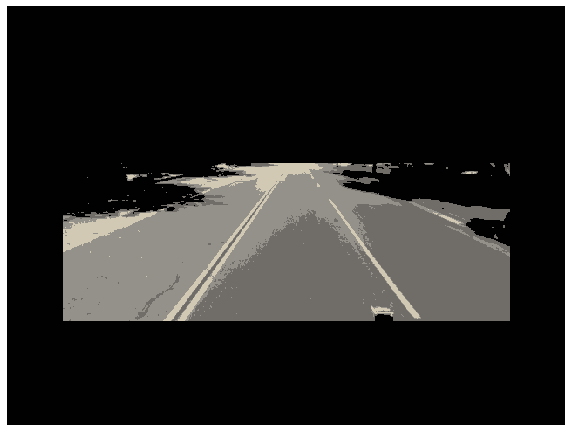

In [36]:
cropped_mask = cv2.bilateralFilter(cropped_mask,20,5,80)
Z = cropped_mask.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 4
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((cropped_mask.shape))

plt.figure(figsize= (10,10))
plt.imshow(res2)
plt.axis('off')
plt.show()

This HSV seperation is done to see if the segmented image can seperate out the lanes, this step is done to see if it requires any more noise correction

In [37]:
lb = np.array([0,0,50])
ub = np.array([180,169,210])
road_mask = cv2.inRange(res2,lb,ub)
road = cv2.bitwise_and(image , image , mask = road_mask)

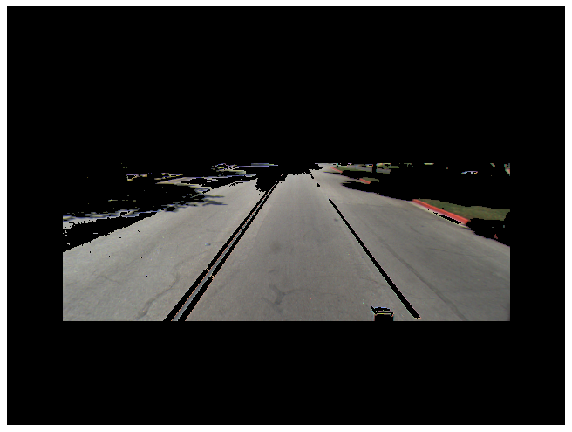

In [38]:
plt.figure(figsize= (10,10))
plt.imshow(road)
plt.axis('off')
plt.show()

Finally the the images didn't required to have histogram correction, gamma correction or bilateral filtering. So,
the Canny edge detection is applied and it takes care of the bluring and gives good desired results.
But still it has some noise 

In [40]:
k_edges = cv2.Canny(cropped_mask,100,150,7,L2gradient = True)

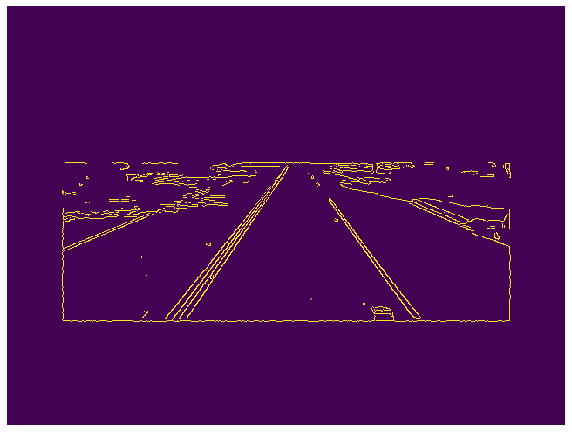

In [41]:
plt.figure(figsize= (10,10))
plt.imshow(k_edges)
plt.axis('off')
plt.show()

# This noise is removed by again masking the interest area and cropping out 

In [45]:
height = image.shape[0]
width = image.shape[1]
image_vertex = [(width*1.1/10, height*2.9/4), (width*1.1/10, height*1.2/2),(width/2,height*1.1/3), 
                (width*8.9/10, height*2.9/4)]
  
def edge_mask(edges,vertex):
    mask = np.zeros_like(edges)
    #channel_count = image.shape[2]
    match_mask_color = 255
    cv2.fillPoly(mask, np.array([image_vertex], np.int32), match_mask_color)
    masked_image = cv2.bitwise_and(edges, mask)
    return masked_image

In [46]:
masked_edges = edge_mask(k_edges, image_vertex)

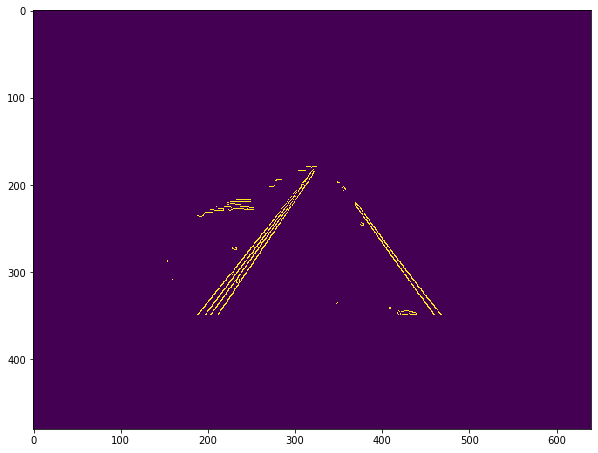

In [47]:
plt.figure(figsize= (10,10))
plt.imshow(masked_edges)
#plt.axis('off')
plt.show()

Now hough lines are plotted in the canny edge detected image to get the lanes detected image

In [257]:
cdst = cv2.cvtColor(masked_edges, cv2.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)

In [264]:
def drow_the_lines(img, lines):
    img = np.copy(img)
    blank_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(blank_image, (x1,y1), (x2,y2), (0, 255, 0), thickness=4)

    img = cv2.addWeighted(img, 0.8, blank_image, 1, 0.0)
    return img

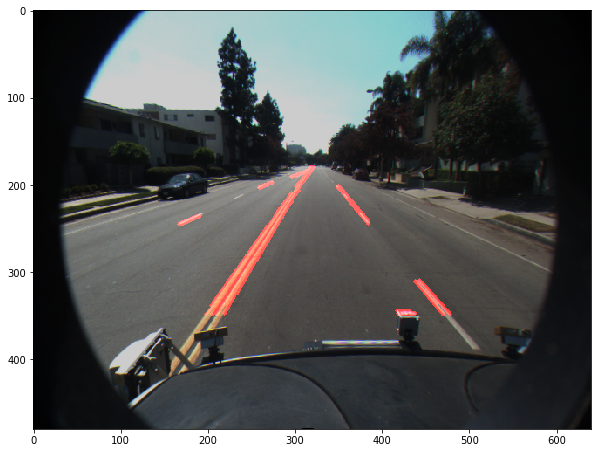

In [259]:
lines = cv2.HoughLinesP(masked_edges,rho=6,
                        theta=np.pi/180,
                        threshold=40,
                        lines=np.array([]),
                        minLineLength=10,
                        maxLineGap=25)
image_with_lines = drow_the_lines(image, lines)
plt.figure( figsize= (10,10))
plt.imshow(image_with_lines)
plt.show()

# # Finally a loop to itreate over several images to impliment the method

In [271]:
filenames = os.listdir("/home/zahidfaiz/zahiddocuments/VR/roads/cordova1/")
for filename in filenames:
    try:
        image= cv2.imread("/home/zahidfaiz/zahiddocuments/VR/roads/cordova1/" + filename)
        image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
        cropped_mask = masking_image(image) 
        k_edges = cv2.Canny(cropped_mask,100,150,7,L2gradient = True)    
        masked_edges = edge_mask(k_edges, image_vertex)   
        cdst = cv2.cvtColor(masked_edges, cv2.COLOR_GRAY2BGR)
        lines = cv2.HoughLinesP(masked_edges,
                            rho=6,
                            theta=np.pi/180,
                            threshold=120,
                            lines=np.array([]),
                            minLineLength=10,
                            maxLineGap=25)
        image_with_lines = drow_the_lines(image, lines)
        plt.imsave("/home/zahidfaiz/zahiddocuments/VR/roads/cordova2op/"+filename + "i.jpg", image_with_lines)
    except:
        pass

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 